# Overview

This notebook steps through non-CNN models for ship identification, including: Logistic Regression, SVM, and Decision Tress.

* From planet data over SF Bay (hosted on Kaggle): https://www.kaggle.com/rhammell/ships-in-satellite-imagery
* 2800 80x80 RGB images labeled ship or no-ship
* 700 ships
* 2100 no ships


# Imports

In [4]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import json  
import mpl_toolkits
import os
import pickle
import glob
import re
import itertools
from PIL import Image
import time


import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report





import xgboost as xgb
from xgboost import XGBClassifier

# import tensorflow as tf
# import keras
# from keras import backend as K
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
# from keras import initializers, layers, models
# from keras.utils import to_categorical
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from keras import callbacks
# from keras.utils.vis_utils import plot_model
%matplotlib inline



from skimage.feature import hog
from skimage import data, color, exposure
from sklearn import cross_validation

In [5]:
sklearn.__version__

'0.19.1'

# load images

In [6]:
os.listdir("shipsnet_data/shipsnet");

In [7]:
path =r'/Users/mayamidzik/cv/shipsnet/shipsnet_data/shipsnet'

In [8]:
boats = glob.glob(os.path.join(path,'1*.png'))
no_boats = glob.glob(os.path.join(path,'0*.png'))

# Subset boats and create image arrays

In [9]:
#make one large array of data
boats.extend(no_boats)

In [10]:
#create arrays for all image data (contains nested arrays of pixels) and image labels (based on file name) 

image_data = []
image_tag = []

def makeImageDataTagArray(files_list):
    positive = re.compile("/Users/mayamidzik/cv/shipsnet/shipsnet_data/shipsnet/1.*")
    negative = re.compile("/Users/mayamidzik/cv/shipsnet/shipsnet_data/shipsnet/0.*")
    for i in files_list:
        if positive.match(i):
            image_tag.append(1)
        if negative.match(i):
            image_tag.append(0)
        img = Image.open(i)
        arr = np.array(img)
        image_data.append(arr)
        
makeImageDataTagArray(boats)

In [11]:
len(image_tag)

2798

In [18]:
image_data[1].shape

(80, 80, 3)

In [11]:
#dataframe if you want to look at the data
# d = {'image': image_data, 'tag': image_tag}
# df = pd.DataFrame(data = d)

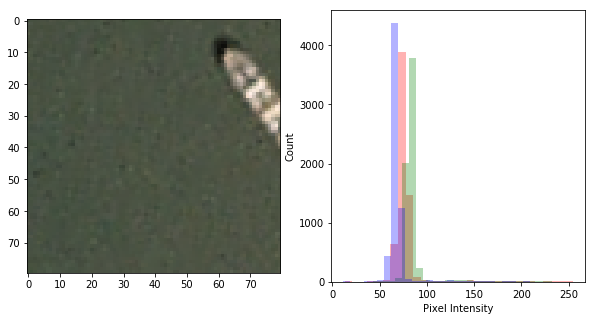

In [12]:
#This was borrowed partially from histogram of https://www.kaggle.com/rhammell/

def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='red', alpha=0.3);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='green', alpha=0.3);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='blue', alpha=0.3);

plotHistogram(image_data[-9])

# Create Transformations of images

## Testing flip and rotate

In [15]:
test = image_data[4]

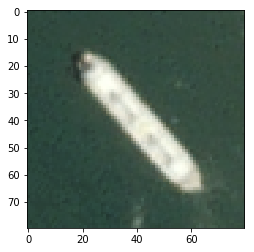

In [16]:
plotOne(test)

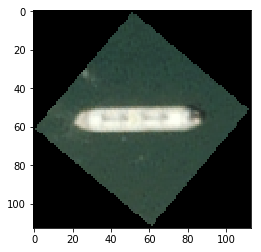

In [17]:
#rotate around the unit circle
from scipy import ndimage

rot = ndimage.interpolation.rotate(test,230, mode = 'constant')
plotOne(rot)

## Run HOG on images

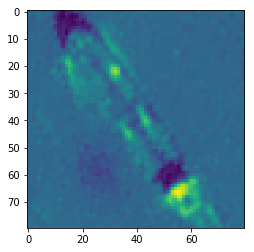

In [78]:
data_gray = [ color.rgb2gray(i) for i in image_data]
plt.imshow(data_gray[51])

In [85]:
ppc = 12
hog_images = []
hog_features = []
for image in data_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualise=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

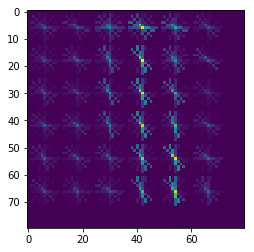

In [86]:
plt.imshow(hog_images[0])

# Test out different models

## Make vectors for modeling & create a test split

In [21]:
#vectorize images for models
def make_vector(image_list):
    vectors = []
    for image in image_list:
        vector = np.ravel(image)
        vectors.append(vector)
    return np.array(vectors)
    

In [23]:
x_vect = make_vector(image_data)
y_vect = np.ravel(image_tag)


In [24]:
#dump to picle for CNN evaluation
pickle.dump(x_vect, open( "x_vect.pkl", "wb" ) )
pickle.dump(y_vect, open( "y_vect.pkl", "wb" ) )
pickle.dump(image_data, open( "image_data.pkl", "wb" ) )
pickle.dump(image_tag, open( "image_tag.pkl", "wb" ) )


In [25]:
#try just using shuffle
xtrain, xtest, ytrain, ytest = train_test_split(x_vect, y_vect, test_size=0.2, random_state = 1234, stratify = y_vect, shuffle = True)

# xhogtrain, xhogtest, ytrain, ytest = train_test_split(x_hog_vect, y_vect, test_size=0.2, random_state = 1234, stratify = y_vect, shuffle = True)



## helper methods for classifiers

In [26]:
# Generate a confusion matrix plot: 
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def test_model(model, xtrain, ytrain, xtest, ytest):
    
    start_time = time.time()
    clf = model.fit(xtrain, ytrain)
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))

    y_true = ytest
    y_pred = clf.predict(xtest)

    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))


    cm=confusion_matrix(y_true, y_pred, labels=None)

    plt.figure()
    plot_confusion_matrix(cm)

    print("--- %s seconds ---" % (time.time() - start_time))

## Test each model individually (Knn, LogReg, SVC, Decision Trees)

Training Data Accuracy: 0.98
Test Data Accuracy:     0.93
[[407  13]
 [ 25 115]]


Precision:              0.94
Recall:                 0.97
Specificity:              0.82
--- 52.720876932144165 seconds ---


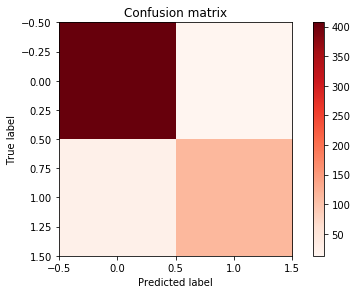

In [30]:
#test Knn

Knn=  KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
test_model(Knn, xtrain, ytrain, xtest, ytest)


In [ ]:
#seach for the optimal value of K for KNN
k_range = list(range(1, 10))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
    scores = cross_val_score(knn, xtrain, ytrain, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)
#note that k = 2 seems the highest in this range

Training Data Accuracy: 1.00
Test Data Accuracy:     0.88
[[370  50]
 [ 18 122]]


Precision:              0.95
Recall:                 0.88
Specificity:              0.87
--- 29.89971685409546 seconds ---
--- 29.89988088607788 seconds ---


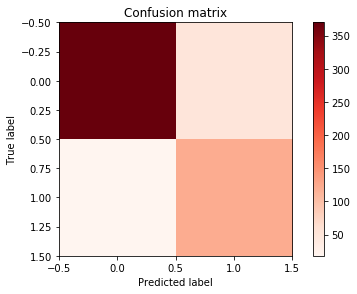

In [59]:
#LogReg
start_time = time.time()

lr = LogisticRegression()
test_model(lr, xtrain, ytrain, xtest, ytest)

Training Data Accuracy: 1.00
Test Data Accuracy:     0.95
[[403  17]
 [ 10 130]]


Precision:              0.98
Recall:                 0.96
Specificity:              0.93
--- 87.49527192115784 seconds ---


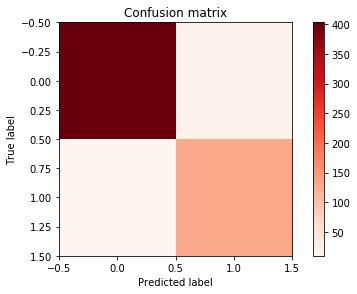

In [27]:
#SVC
svc = SVC(kernel = 'poly',degree = 2)
    
test_model(svc, xtrain, ytrain, xtest, ytest)


Training Data Accuracy: 1.00
Test Data Accuracy:     0.96
[[407  13]
 [  8 132]]


Precision:              0.98
Recall:                 0.97
Specificity:              0.94
--- 77.8677430152893 seconds ---


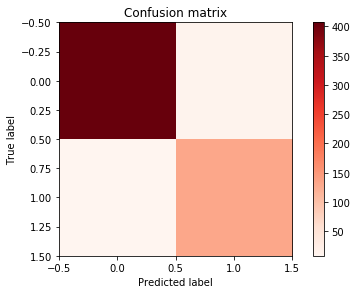

In [29]:
#SVC
svc = SVC(kernel = 'poly',degree = 3)
    
test_model(svc, xtrain, ytrain, xtest, ytest)

## Test Decision Tree

Training Data Accuracy: 1.00
Test Data Accuracy:     0.93
[[414   6]
 [ 31 109]]


Precision:              0.93
Recall:                 0.99
Specificity:              0.78
--- 1.4553661346435547 seconds ---


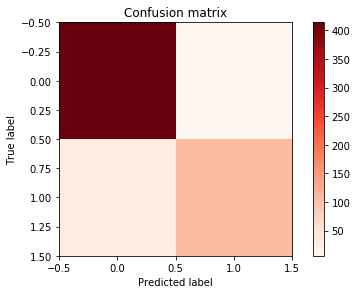

In [28]:
clf = RandomForestClassifier()
test_model(clf, xtrain, ytrain, xtest, ytest)

## Compare Models

In [69]:
models = []
models.append(('LR', LogisticRegression()))
# models.append(('KNN', KNeighborsClassifier(n_neighbors=2, n_jobs=-1))) 
models.append(('SVC_poly', SVC(kernel = 'poly',degree = 3)))
# models.append(('SVC_linear', SVC(kernel='linear')))
# models.append(('SVC_rbf', SVC(kernel='rbf', gamma = 0.001)))
# models.append(('random_forest', RandomForestClassifier()))

    
    
resultsTrainAccuracy = []
resultsTestAccuracy = []
resultsPrecision = []
resultsRecall = []
resultsSpecificity = []
resultsFprTPr = []
resultsAuc = []

names = []

for name, model in models:
    print(name)
    names.append(name)
    clf = model.fit(xtrain, ytrain)
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    resultsTrainAccuracy.append(train_acc)
    resultsTestAccuracy.append(test_acc)
    y_true = ytest
#     y_pred = clf.predict(xtest)
#     y_score=clf.predict_proba(xtest)[:,1]
#     fpr, tpr,_ = roc_curve(ytest, y_score)
#     resultsFprTPr.append((fpr,tpr))
#     roc_auc = auc(fpr, tpr)
#     resultsAuc.append(roc_auc)

    conf = confusion_matrix(y_true, y_pred)

    Precision = (conf[0, 0] / (conf[0, 0] + conf[1, 0]))
    resultsPrecision.append(Precision)
    Recall = (conf[0, 0] / (conf[0, 0] + conf[0, 1]))
    resultsRecall.append(Recall)
    Specificity = (conf[1, 1] / (conf[1, 1] + conf[1, 0]))
    resultsSpecificity.append(Specificity)


In [ ]:
d = {'model': names, 'train_accuracy': resultsTrainAccuracy, 'test_accuracy':resultsTestAccuracy, 
     'precision' : resultsPrecision, 'recall' : resultsRecall, 'specificity' :resultsSpecificity
    }
models_df = pd.DataFrame(data = d)
models_df

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Accuracy')
ax = fig.add_subplot(111)
plt.bar(names, resultsSpecificity)
ax.set_xticklabels(names)
ax.set_ylabel('Accuracy Score')
plt.show()

# Optimize the SVM

In [118]:
#run a grid search to find optimal parameters for SVM
#define hyperparameters
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
tuned_parameters = [{'kernel': ['rbf'], 'gamma': gammas,
                     'C': Cs},
                    {'kernel': ['linear'], 'C': Cs},
                   {'kernel': ['poly'], 'degree':[2,3,4], 'gamma': gammas,
                     'C': Cs}]

In [113]:
#code adampted from sklearn documentation here: 
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(xtrain, ytrain)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    with open('gridResults.pkl', 'wb') as picklefile:
        pickle.dump(clf, picklefile)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = ytest, clf.predict(xtest)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

KeyboardInterrupt: 

In [115]:
clf.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'